In [1]:
# DataSet
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#import helper

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)) 
])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download = True, train = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download = True, train = False, transform = transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)




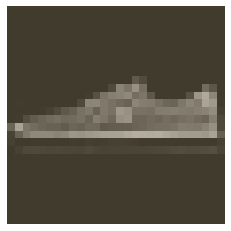

In [2]:
#test image

def imgshow(image, ax = None, title = None, normalize = True ):
    
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std*image+mean
        image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis = 'both', length = 0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax
image, label = next(iter(trainloader))

imgshow(image[0, :]);

In [5]:
# make the network 
"""
input layer: 28*28 = 764
hidden layer: 2개, 258, 128
output layer: 10개 (구별할 옷이 열 종류)
Adam Optimizer과 NLLLoss 활용
"""

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim = 1)
        return x

    
        
        

In [6]:
# train a model
model = Classifier()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)
epochs = 20

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #모델에서 훈련
        result = model(images)
        #오차 계산
        loss = criterion(result, labels)
        
        #초기화
        optimizer.zero_grad()
        
        #역전파
        loss.backward()
        
        #스텝
        optimizer.step()
        
        #오차값을 총 오차에 더함
        running_loss += loss.item()
        
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
        
        

Training loss: 0.5113844161253494
Training loss: 0.3896492956194288
Training loss: 0.35126941513691123
Training loss: 0.3302879740100807
Training loss: 0.3172318193513447
Training loss: 0.3012649041614426
Training loss: 0.29171093157740796
Training loss: 0.28120368981221594
Training loss: 0.27310153312170937
Training loss: 0.2632431341990479
Training loss: 0.25982061635329523
Training loss: 0.25059708373061124
Training loss: 0.24553539502277558
Training loss: 0.24125539998748283
Training loss: 0.23521060668932858
Training loss: 0.23163919098405186
Training loss: 0.2269195280015977
Training loss: 0.22057048483555125
Training loss: 0.2212700649007742
Training loss: 0.21950611309694457


In [7]:

"""
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
img = img.resize(1, 784)
ps = torch.exp(model(img))
helper.view_classify(img.resize_(1, 28, 28), ps, version = 'Fashion')
"""

"\ndataiter = iter(testloader)\nimages, labels = dataiter.next()\nimg = images[0]\nimg = img.resize(1, 784)\nps = torch.exp(model(img))\nhelper.view_classify(img.resize_(1, 28, 28), ps, version = 'Fashion')\n"

In [9]:
# Accuracy

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        #자동 미분을 꺼서 pytorch가 쓸 떼 없는 짓을 안한다. 
        with torch.no_grad():
            for images, labels in testloader:
                
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                #로그 확률에 지수 적용
                ps = torch.exp(log_ps)
                
                #k번째로 큰 숫를 찾아낸다 / dim = 1 은 dimension을 의미한다.
                top_p, top_class = ps.topk(1, dim=1)
                
                #labels를 top_class와 똑같은 형태로 만든 다음에, 얼마나 같은게 있는지 확인한다.
                equals = top_class == labels.view(*top_class.shape)
                
                #equals를 float으로 바꾸고 평균 정확도를 구한다.
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print(
            "Epoch:{}/{}..".format(e+1, epochs),
            "Training Loss : {:.3f}..".format(running_loss / len(trainloader)),
            "Test Loss: {:.3f}..".format(test_loss/len(testloader)),
            "Test Accuracy: {:3f}".format(accuracy/len(testloader))
             )
        
        
                


Epoch:1/20.. Training Loss : 0.210.. Test Loss: 0.187.. Test Accuracy: 0.929604
Epoch:2/20.. Training Loss : 0.206.. Test Loss: 0.183.. Test Accuracy: 0.931753
Epoch:3/20.. Training Loss : 0.207.. Test Loss: 0.177.. Test Accuracy: 0.934951
Epoch:4/20.. Training Loss : 0.204.. Test Loss: 0.191.. Test Accuracy: 0.929238
Epoch:5/20.. Training Loss : 0.196.. Test Loss: 0.187.. Test Accuracy: 0.931053
Epoch:6/20.. Training Loss : 0.200.. Test Loss: 0.178.. Test Accuracy: 0.933902
Epoch:7/20.. Training Loss : 0.193.. Test Loss: 0.200.. Test Accuracy: 0.927872
Epoch:8/20.. Training Loss : 0.188.. Test Loss: 0.160.. Test Accuracy: 0.939116
Epoch:9/20.. Training Loss : 0.184.. Test Loss: 0.173.. Test Accuracy: 0.936700
Epoch:10/20.. Training Loss : 0.190.. Test Loss: 0.192.. Test Accuracy: 0.929604
Epoch:11/20.. Training Loss : 0.185.. Test Loss: 0.169.. Test Accuracy: 0.934885
Epoch:12/20.. Training Loss : 0.178.. Test Loss: 0.165.. Test Accuracy: 0.938833
Epoch:13/20.. Training Loss : 0.179..

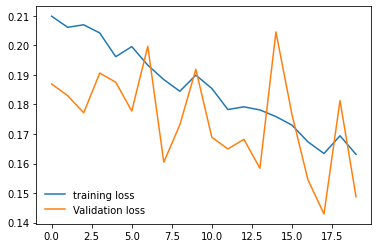

In [10]:
plt.plot(train_losses, label = "training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)